In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import text
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from dateutil.relativedelta import relativedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
meas = Base.classes.measurement
sta = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get column names
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [10]:
# Find the most recent date in the data set.
sel = [func.max(meas.date)]
date_max = session.query(*sel)
date_max[0][0]
# for date in date_max:
#     print(date)

'2017-08-23'

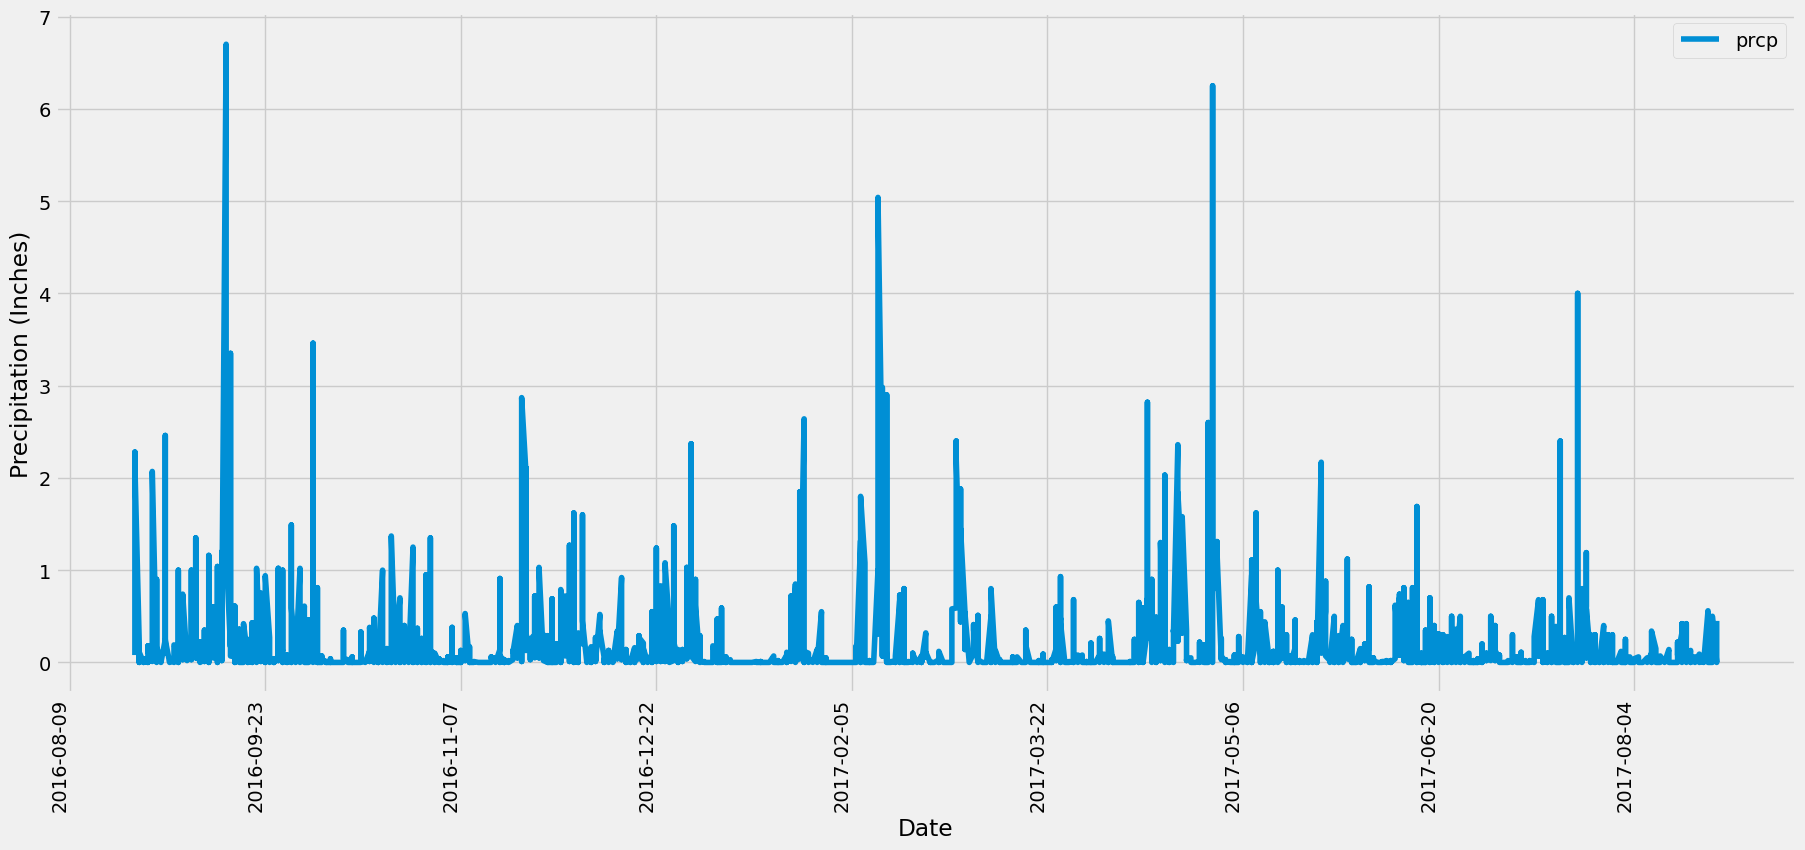

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_max_val = date_max[0][0]
query_date = dt.datetime.strptime(date_max_val, '%Y-%m-%d')
query_date = (query_date - relativedelta(months = 12))

# Perform a query to retrieve the data and precipitation scores
selections = [meas.date, meas.prcp]
results = session.query(*selections).filter(meas.date >= query_date)
# Save the query results as a Pandas DataFrame and set the index to the date column
clim_df = pd.DataFrame(results)
clim_df.set_index('date', inplace=True)
clim_df.index = pd.to_datetime(clim_df.index)

# Drop null
clim_df.dropna(inplace=True)

# Sort the dataframe by date
clim_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

ax = clim_df['prcp'].plot.line(figsize=(20,10))
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend(loc='best')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=45))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data

print(f"The highest precipitation value is {clim_df['prcp'].max()} inches.")
print(f"The lowest precipitation value is {clim_df['prcp'].min()} inches.")
print(f"The average precipitation is {clim_df['prcp'].mean()} inches.")
quartiles = clim_df['prcp'].quantile([0.25, 0.5, 0.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")
upper_bound = upperq + (1.5*iqr)
print(f"Values above {upper_bound} could be outliers.")

The highest precipitation value is 6.7 inches.
The lowest precipitation value is 0.0 inches.
The average precipitation is 0.17727857496288968 inches.
The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values above 0.325 could be outliers.


# Exploratory Station Analysis

In [14]:
# Get column names
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [15]:
df_joined = pd.DataFrame(session.execute(text('select station.station, station.name, measurement.tobs, measurement.date from station join measurement on measurement.station = station.station')))
df_joined.head()

,station,name,tobs,date
0,USC00519397,"WAIKIKI 717.2, HI US",65.0,2010-01-01
1,USC00519397,"WAIKIKI 717.2, HI US",63.0,2010-01-02
2,USC00519397,"WAIKIKI 717.2, HI US",74.0,2010-01-03
3,USC00519397,"WAIKIKI 717.2, HI US",76.0,2010-01-04
4,USC00519397,"WAIKIKI 717.2, HI US",73.0,2010-01-06


In [16]:
# Design a query to calculate the total number stations in the dataset
df_joined['station'].nunique()

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

station_counts = df_joined['station'].value_counts()
station_counts = station_counts.to_frame()
station_counts.reset_index(inplace=True)
station_counts.rename(columns = {'index' : 'station ID', 'station' : 'count'}, inplace=True)

# List the stations and the counts in descending order.
station_counts.sort_values('count', ascending=False, inplace=True)
high_obsv = station_counts.iloc[0,0]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

high_obsv_df = df_joined[df_joined['station'] == high_obsv]
min_temp = high_obsv_df['tobs'].min()
max_temp = high_obsv_df['tobs'].max()
avg_temp = high_obsv_df['tobs'].mean()

print(f'The lowest temperature is {min_temp} F')
print(f'The highest temperature is {max_temp} F')
print(f'The average temperature is {round(avg_temp, 2)} F')


The lowest temperature is 54.0 F
The highest temperature is 85.0 F
The average temperature is 71.66 F


In [19]:
# Calculate query date to filter by

date_max_2 = df_joined['date'].max()
date_max_2
query_date_2 = dt.datetime.strptime(date_max_2, '%Y-%m-%d').date()
query_date_2 -= relativedelta(years=1)
query_date_2

datetime.date(2016, 8, 23)

In [20]:
date_conv = []
temp = high_obsv_df['date']
temp = list(temp)
for date in temp:
    date_conv.append(dt.datetime.strptime(date, '%Y-%m-%d').date())
    
date_conv

high_obsv_df['date'] = date_conv


/var/folders/78/238gl0sx3sv0k3ys61_lz22w0000gn/T/ipykernel_2499/3182612463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_obsv_df['date'] = date_conv


In [21]:
high_obsv_df.head()

,station,name,tobs,date
12187,USC00519281,"WAIHEE 837.5, HI US",70.0,2010-01-01
12188,USC00519281,"WAIHEE 837.5, HI US",62.0,2010-01-02
12189,USC00519281,"WAIHEE 837.5, HI US",74.0,2010-01-03
12190,USC00519281,"WAIHEE 837.5, HI US",75.0,2010-01-04
12191,USC00519281,"WAIHEE 837.5, HI US",74.0,2010-01-05


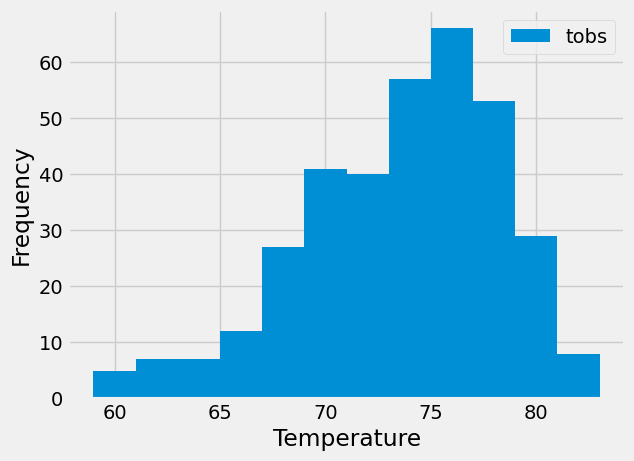

In [22]:
# Using the most active station id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plot_df = high_obsv_df[high_obsv_df['date'] >= query_date_2]

plot_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

# Close session

In [28]:
# Close Session
session.close()